<a href="https://colab.research.google.com/github/nati-curious/NLP-playground/blob/main/text_classification_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Описание задачи

Создайте модель, обрабатывающую фрагмент текста и определяющую,
какой вид продукции в нём содержится.

Датасет поделите на 80% / 20% - обучающая/тестовая выборки.

Используйте библиотеку PyTorch.

Виды продукции (брать только виды продукции, для которых в датасете есть не менее 500 примеров):

Баранина
Ягнятина
Индейка
Говядина
Свинина
Кура
Цыплено
Гусь
Буйволятина
Оленина
Конина
Телятина
Кролик
Утка
Куропатка
Перепел
Глухарь
Страус
Заяц
Кенгуру
Изюбр
Кабан
Коза
Косуля
Лось
Марал
Медвежатина
Бобер
Цесарка
Нутрия
Рябчик
Тетерев
Фазан
Як

Примеры входных текстов и видов продукции:\
Набор для бульона свиной\
Набор для бульона свиной, в наличии, 76р/кг. -> Свинина\
Мясо премиум Предлагаем котлетное мясо мраморной говядины. -> Говядина\
спинка цб -> Цыпленок

Проверьте вашу модель на образцах:\
Говядина блочная 2 сорт в наличии ООО “АгроСоюз” реализует блочную говядину 2 сорт (80/20)\
Свободный объем 8 тонн Самовывоз или доставка. Все подробности по телефону.\
Куриная разделка Продам кур и куриную разделку гост и халяль по хорошей цене .Тел:\
Говяжью мукозу Продам говяжью мукозу в охл и замороженном виде. Есть объем.

# Импорт библиотек и фреймворков

In [1]:
!python -m spacy download ru_core_news_sm

2023-12-12 08:16:05.041573: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-12 08:16:05.041668: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-12 08:16:05.041704: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-12 08:16:05.048644: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-12 08:16:06.325615: W tensorflow/compiler/

In [2]:
pip install emoji --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 397.5/397.5 kB 9.3 MB/s eta 0:00:00


In [6]:
!pip install -q torchmetrics -U mlxtend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.0 MB/s eta 0:00:00


In [73]:
import os
from pathlib import Path
import time
import csv
import random
import re
import string
import emoji

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import spacy
spacy.load('ru_core_news_sm')

import torch
import torchtext
from torch.utils.data import (
    DataLoader,
    Dataset,
    random_split
)
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import (
    Vocab,
    build_vocab_from_iterator
)
from torchtext.data.functional import to_map_style_dataset
from torch import nn

import torchmetrics
from torchmetrics import ConfusionMatrix

# Разведочный анализ, очистка и подготовка данных

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
df = pd.read_csv("/content/drive/MyDrive/meattypes.csv", delimiter=';')
df.head()

,text,mtype
0,12 частей баранина 12 частей баранина,Баранина
1,"Баранина, 12 частей, зам. цена 260 руб.",Баранина
2,"Баранина, 12 частей, зам. цена 315 руб.",Баранина
3,"Баранина, 12 частей, охл.",Баранина
4,"Баранина, 12 частей, охл. цена 220 руб.",Баранина


In [ ]:
# Выводит пример текста, содержащегося в столбце text
df.text[17300]

'Свинина закупаем:\n\nна Постоянной\nоснове Свиной\nтонкий кишечник замороженный!  только без жира!\nналичный расчет'

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17893 entries, 0 to 17892
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    17893 non-null  object
 1   mtype   17892 non-null  object
dtypes: object(2)
memory usage: 279.7+ KB


In [10]:
# Группирует и выводит значения столбца `mtype`, количество которых превышает 500 примеров
labels_500 = df.mtype.value_counts().loc[lambda x: x > 500].reset_index()['index']
labels_500

0    Говядина
1     Свинина
2        Кура
3     Индейка
4    Баранина
5    Цыпленок
Name: index, dtype: object

Проверим датасет на чистоту — возможно, какие-то столбцы не учтены из-за некорректного внесения данных.

In [ ]:
# Выводит количество элементов в каждой подгруппе
df.mtype.value_counts()

Говядина                                                                                   8422
Свинина                                                                                    3050
Кура                                                                                       1571
Индейка                                                                                    1337
Баранина                                                                                   1116
Цыпленок                                                                                    942
Кролик                                                                                      334
Утка                                                                                        195
Оленина                                                                                     193
Конина                                                                                      176
Гусь                                    

In [11]:
# Приводит названия категорий к единому виду
df = df.replace({'mtype' : { 'свиниеа': 'Свинина', 'свинина': 'Свинина', 'цыпленок': 'Цыпленок', \
                       'индейка': 'Индейка', 'говядина': 'Говядина', 'утка': 'Утка', \
                        np.nan: '?'}})

In [12]:
nan_string = df[df.mtype == '?']
nan_string

,text,mtype
7904,Филе окорочка бк бк Филе окорочка куриного б/...,?


In [13]:
# Заменяет '?' на 'Кура'
df['mtype'] = df['mtype'].replace('?', 'Кура')

In [14]:
rub_125 = df[df.mtype == '125р.']
rub_125

,text,mtype
1090,Голень куриная с/м монолит Гост Голень курина...,125р.


In [15]:
# Заменяет '125р.' на 'Кура'
df['mtype'] = df['mtype'].replace('125р.', 'Кура')

In [16]:
df.text[1090] = 'Голень куриная с/м монолит Гост Голень куриная с/м натуральная монолит ' + '125 р.'
df.text[1090]

'Голень куриная с/м монолит Гост Голень куриная с/м натуральная монолит 125 р.'

In [17]:
rub_295 = df[df.mtype == '295,00 руб|кг']
rub_295

,text,mtype
10339,Карбонад свиной б/к гофра 20-23 кг Карбонад св...,"295,00 руб|кг"


In [18]:
df['mtype'] = df['mtype'].replace('295,00 руб|кг', 'Свинина')

In [19]:
df.text[10339] = 'Карбонад свиной б/к гофра 20-23 кг Карбонад свиной б/к гофра 20-23 кг. ' + '295,00 руб|кг'
df.text[10339]

'Карбонад свиной б/к гофра 20-23 кг Карбонад свиной б/к гофра 20-23 кг. 295,00 руб|кг'

In [20]:
govyadina = df[df.mtype == 'Говядина, полутуши, 1 категория,  охл., Россия, подвес, В наличии, 10 тонн, 270 руб. кг']
govyadina

,text,mtype
5494,,"Говядина, полутуши, 1 категория, охл., Россия..."


In [21]:
df = df.replace({'mtype' : { 'Говядина, полутуши, 1 категория,  охл., Россия, подвес, В наличии, 10 тонн, 270 руб. кг': 'Говядина'},
                 'text' : { '  ': 'Говядина, полутуши, 1 категория,  охл., Россия, подвес, В наличии, 10 тонн, 270 руб. кг'}})

In [22]:
df.iloc[5494]

text     Говядина, полутуши, 1 категория,  охл., Россия...
mtype                                             Говядина
Name: 5494, dtype: object

In [23]:
buivol = df[df.mtype == ' Лопаточная часть (Chuck) буйвол ']
buivol

,text,mtype
12848,Лопаточная часть (Chuck) буйвол,Лопаточная часть (Chuck) буйвол


In [24]:
df['mtype'] = df['mtype'].replace(' Лопаточная часть (Chuck) буйвол ', 'Буйволятина')

In [25]:
df.iloc[12848]

text     Лопаточная часть (Chuck) буйвол 
mtype                         Буйволятина
Name: 12848, dtype: object

In [26]:
feb = df[df.mtype == 'Feb-20']
feb

,text,mtype
14793,окорочка Окорочка куриные,Feb-20
15460,печень куринная Печень куриная,Feb-20


In [27]:
df['mtype'] = df['mtype'].replace('Feb-20', 'Кура')

In [28]:
df.text[14793] = 'окорочка Окорочка куриные ' + 'Feb-20'
df.text[15460] = 'печень куринная Печень куриная ' + 'Feb-20'

In [29]:
df.iloc[[14793, 15460]]

,text,mtype
14793,окорочка Окорочка куриные Feb-20,Кура
15460,печень куринная Печень куриная Feb-20,Кура


In [30]:
mar = df[df.mtype == 'Mar-20']
mar

,text,mtype
14794,окорочка Окорочка куриные б/х,Mar-20


In [31]:
df['mtype'] = df['mtype'].replace('Mar-20', 'Кура')
df.text[14794] = 'окорочка Окорочка куриные б/х ' + 'Mar-20'
df.iloc[14794]

text     окорочка Окорочка куриные б/х Mar-20
mtype                                    Кура
Name: 14794, dtype: object

In [32]:
arg = df[df.mtype == 'OFFAL EXP №4407 Аргентина']
arg

,text,mtype
15280,"Печень говяжья Аргентина ,ЗАМ Печень говяжья ...",OFFAL EXP №4407 Аргентина


In [33]:
arg_2 = df[df.mtype == '(OFFAL EXP №4407 Аргентина)']
arg_2

,text,mtype
15182,Печень говяжья Аргентина зам Печень говяжья...,(OFFAL EXP №4407 Аргентина)


In [34]:
df['mtype'] = df['mtype'].replace('OFFAL EXP №4407 Аргентина', 'Говядина')

In [35]:
df.drop([15182], axis=0, inplace=True)
df.reset_index(inplace=True, drop=True)

In [36]:
df.head()

,text,mtype
0,12 частей баранина 12 частей баранина,Баранина
1,"Баранина, 12 частей, зам. цена 260 руб.",Баранина
2,"Баранина, 12 частей, зам. цена 315 руб.",Баранина
3,"Баранина, 12 частей, охл.",Баранина
4,"Баранина, 12 частей, охл. цена 220 руб.",Баранина


In [ ]:
df.mtype.value_counts()

Говядина       8425
Свинина        3055
Кура           1576
Индейка        1339
Баранина       1116
Цыпленок        944
Кролик          334
Утка            196
Оленина         193
Конина          176
Гусь            125
Телятина         98
Буйволятина      76
Ягнятина         76
Перепел          54
Кабан            24
Лось             20
Страус           10
Косуля            8
Куропатка         7
Марал             7
Цесарка           7
Фазан             4
Медвежатина       4
Изюбр             3
Нутрия            2
Як                2
Кенгуру           2
Заяц              2
Парагвай          2
Коза              1
Бобер             1
Рябчик            1
Тетерев           1
Глухарь           1
Name: mtype, dtype: int64

In [37]:
# Создает датасет с категориями, в которых значений больше 500
df_500 = df[
    (df.mtype == 'Говядина') | (df.mtype == 'Свинина') | (df.mtype == 'Кура') |
     (df.mtype == 'Индейка')  | (df.mtype == 'Баранина') | (df.mtype == 'Цыпленок')]
df_500 = df_500.reset_index(drop=True)
df_500.head()

,text,mtype
0,12 частей баранина 12 частей баранина,Баранина
1,"Баранина, 12 частей, зам. цена 260 руб.",Баранина
2,"Баранина, 12 частей, зам. цена 315 руб.",Баранина
3,"Баранина, 12 частей, охл.",Баранина
4,"Баранина, 12 частей, охл. цена 220 руб.",Баранина


In [38]:
# Проверяет, есть ли дубликаты
df_500.duplicated().sum()

4

In [39]:
# Удаляет дубликаты
df_500.drop_duplicates(ignore_index=True, inplace=True)

In [40]:
df_500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16451 entries, 0 to 16450
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16451 non-null  object
 1   mtype   16451 non-null  object
dtypes: object(2)
memory usage: 257.2+ KB


In [41]:
# Сохраняет датасет в формате CSV на MyDrive
os.makedirs('/content/drive/MyDrive', exist_ok=True)
df_500.to_csv('/content/drive/MyDrive/df_500.csv', index=False)

In [42]:
# Кодирует классы
df_500 = df_500.replace({'mtype' : { "Говядина": 1, "Свинина": 2, "Кура": 3, \
                                    "Индейка": 4, "Баранина": 5, "Цыпленок": 6}})

In [43]:
# Делит датасет на колонки с признаками и лейблами
texts = df_500['text']
labels = df_500['mtype']

In [44]:
df_500.head()

,text,mtype
0,12 частей баранина 12 частей баранина,5
1,"Баранина, 12 частей, зам. цена 260 руб.",5
2,"Баранина, 12 частей, зам. цена 315 руб.",5
3,"Баранина, 12 частей, охл.",5
4,"Баранина, 12 частей, охл. цена 220 руб.",5


## Препроцессинг текста

In [45]:
# Заменяет emoji на текстовое значение
df_500['text'] = df_500['text'].apply(emoji.demojize)

# Удаляет символы !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
df_500['text'] = df_500['text'].apply(lambda s: s.translate(str.maketrans('', '', string.punctuation)))

In [47]:
# Удаляет HTML, XML, разметку, метаданные, etc.
def remove_html(text):
    pattern = re.compile('<.*?>')
    return pattern.sub(r'',text)

# Удаляет URL
def remove_url(text):
    url = re.compile(r'http(s*)?://\S+|www\.\S+')
    return url.sub(r'',text)

# Окрывает сокращения
def decontracted(phrase):
    phrase = re.sub(r"руб", "рублей", phrase)
    return phrase

def cleaning(text):
    text = text.strip()  # remove white spaces (horizontal tabs)
    text = text.lower()
    text = remove_html(text)
    text = remove_url(text)
    text = decontracted(text)

    return text

In [48]:
texts = df_500['text'].apply(lambda x : cleaning(x))

In [49]:
# Создает класс MeatTypes
class MeatTypes(Dataset):
    def __init__(self, txt, label):
        self.label = labels
        self.text = texts

    def __len__(self):
        return len(self.text)

    def __getitem__(self, idx):
        label = self.label[idx]
        text = self.text[idx]
        return label, text

In [50]:
# Создает объект класса Dataset
dataset = MeatTypes(texts, labels)

In [ ]:
# Выводит сэмпл
dataset.__getitem__(0)

(5, '12 частей баранина  12 частей баранина')

In [51]:
# Делит на обучающую и тестовую выборки в пропорции 80/20
train_iter, test_iter = random_split(dataset, [0.8, 0.2])

In [52]:
# Инициализирует токенайзер
tokenizer = get_tokenizer('spacy', language='ru_core_news_sm')

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)


# Создает словарь на основе обучающей выборки
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

#  Построение, тренировка и оценка качества модели

In [53]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [55]:
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

Слой nn.EmbeddingBag показывает себя эффективным при решении сравнительно простых задач классификации текста, предложения в которых являются короткими. Для них достаточно использовать базовые нейросети, а не рекуррентные – например, такие как LSTM или Transformer.

In [56]:
# Создает класс модели
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [57]:
num_class = len(set([label for (label, text) in train_iter]))
vocab_size = len(vocab)
emsize = 64
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)
print(f"Количество классов: {num_class}")
print(f"Размер словаря: {vocab_size}")
# Выводит параметры модели
print(model)

Количество классов: 6
Размер словаря: 17830
TextClassificationModel(
  (embedding): EmbeddingBag(17830, 64, mode='mean')
  (fc): Linear(in_features=64, out_features=6, bias=True)
)


In [58]:
def train(dataloader):
    model.train()
    train_loss = 0
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        train_loss += loss.item()  # from mrdbrouke
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    train_loss = train_loss / len(dataloader)
    return train_loss


def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    true_labels, predicted_labels = [], []

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
            true_labels.extend(label.cpu().numpy())
            predicted_labels.extend(predicted_label.argmax(1).cpu().numpy())

    return total_acc / total_count, true_labels, predicted_labels

In [61]:
EPOCHS = 20
LR = 5
BATCH_SIZE = 64

criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1, verbose=True)

total_accu = None

train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_test, true_labels, predicted_labels = evaluate(test_dataloader)
    if total_accu is not None and total_accu > accu_test:
        scheduler.step()
    else:
        total_accu = accu_test
    print("-" * 59)
    print(
        "| end of epoch {:3d} | time: {:5.2f}s | "
        "test accuracy {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, accu_test
        )
    )

Adjusting learning rate of group 0 to 5.0000e+00.
-----------------------------------------------------------
| end of epoch   1 | time:  2.08s | test accuracy    0.939 
-----------------------------------------------------------
| end of epoch   2 | time:  1.97s | test accuracy    0.942 
Adjusting learning rate of group 0 to 5.0000e-01.
-----------------------------------------------------------
| end of epoch   3 | time:  2.08s | test accuracy    0.941 
-----------------------------------------------------------
| end of epoch   4 | time:  2.38s | test accuracy    0.944 
-----------------------------------------------------------
| end of epoch   5 | time:  2.79s | test accuracy    0.944 
Adjusting learning rate of group 0 to 5.0000e-02.
-----------------------------------------------------------
| end of epoch   6 | time:  2.25s | test accuracy    0.944 
Adjusting learning rate of group 0 to 5.0000e-03.
-----------------------------------------------------------
| end of epoch   7 |

## Матрица несоответствий

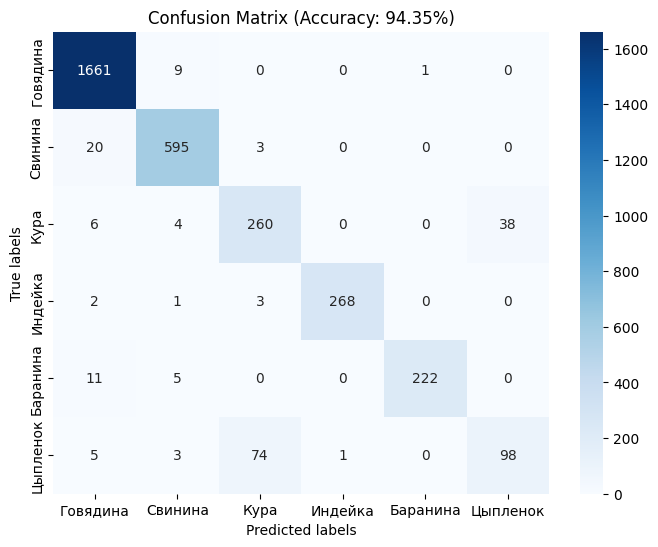

In [63]:
# Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(labels_500), task='multiclass')
confmat_tensor = confmat(preds=torch.from_numpy(np.array(predicted_labels)),
                         target=torch.from_numpy(np.array(true_labels)))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confmat_tensor, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels_500, yticklabels=labels_500)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title(f"Confusion Matrix (Accuracy: {accu_test * 100:.2f}%)")
plt.show()

Некоторое количество объявлений о цыпленке модель идентефицировала объявления как о куре, а о куре – как о цыпленке.\
Давайте посмотрим тексты объявлений – есть подозрение, что в неправильно классифицированных примерах нет признаков, сигнализирующих о принадлежности к одному из упомянутых классов, либо данные размечены неправильно.

In [ ]:
# Выводит все примеры, размеченные "Кура"
df_500[df_500.mtype == 3]

,text,mtype
179,Бедро ЦБ с хребтом Птицефабрика Краснодонская ...,3
180,Бедро окорочок голень филе головы Бедро ЦБ без...,3
185,Бедро БК БК на подложки В наличии 500 кг бедро...,3
203,Бедро кур без хребта Бедро кур бхр ГОСТ 69рубкг,3
208,Бедро куриное,3
...,...,...
15701,Шеи Куриные Реализуем Шеи ЦБ зам монолит со ск...,3
15702,шеи куриные с кожей продам шеи куриные с кожей...,3
15703,Шеи куриные ЦБпрво РБ Шеи цыплятбройлеров фасо...,3
15704,Шеи цб охлаждённые валом ппленка коробка 15кг\...,3


In [ ]:
# Выводит все примеры, размеченные "Цыпленок"
df_500[df_500.mtype == 6]

,text,mtype
181,недорого Бедро цыпленка бройлера Бедро цыпленк...,6
182,птицефабрикасреднеуральскаябедро 95р В наличии...,6
186,Бедро Бк Бк куриное,6
187,Бедро бройлера оптом в Москве Бедро цыпленка б...,6
199,Бедро кур бх мон ГОСТ 10600 руб ООО Русптица\n...,6
...,...,...
16446,Цыпленок четвертина задняя,6
16447,Цыпленок четвертина задняя цена 100 руб,6
16448,ЦБ Шеи пф Свеженка ГОСТ зам пак Шеи куриные ПО...,6
16449,Цыпленок шея без кожи,6


Как мы видим, в примере с индексом 15703, который относится к классу "Кура", речь идет о цыплятах: "Шеи куриные ЦБ,пр-во РБ. Шеи цыплят-бройлеров...", а в примере с индексом 186 из класса "Цыплята" цыплята не упомянуты: "Бедро Бк Бк (куриное)".



## Проверка модели на образцах

In [64]:
meat_label = {1: "Говядина", 2: "Свинина", 3: "Кура", \
              4: "Индейка", 5: "Баранина", 6: "Цыпленок"}


def predict(text, text_pipeline, model):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item() + 1


samples = ["Говядина блочная 2 сорт в наличии ООО “АгроСоюз” реализует блочную говядину 2 сорт (80/20)",
           "Свободный объем 8 тонн Самовывоз или доставка. Все подробности по телефону.",
           "Куриная разделка Продам кур и куриную разделку гост и халяль по хорошей цене .Тел:",
           "Говяжью мукозу Продам говяжью мукозу в охл и замороженном виде. Есть объем."]

model = model.to("cpu")

preds = []

for sample in samples:
    pred = predict(sample, text_pipeline, model)
    preds.append(pred)

for i, pred in enumerate(preds):
    print(f"Типа мяса в образце {i+1}: {meat_label[pred]}")

Типа мяса в образце 1: Говядина
Типа мяса в образце 2: Говядина
Типа мяса в образце 3: Кура
Типа мяса в образце 4: Говядина


Модель определила типы мяса верно для образцов 1, 3 и 4. Для образца 2 модель определяет каждый раз разный вид мяса, так как текст не содержит каких-либо характерных слов, которые указывали бы на определенный тип мяса.

# Сохранение и загрузка модели



In [65]:
# Создает директорию models (если она еще не существует)
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True
)

# Создает путь для сохранения модели
MODEL_NAME = "text_classification_PyTorch.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Сохраняет параметры модели
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/text_classification_PyTorch.pth


In [67]:
# Создает новый объект TextClassificationModel
loaded_model = TextClassificationModel(
    vocab_size=17830, embed_dim=64, num_class=6
    ).to(device)

# Загружает сохраненные параметры модели
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Передает модель на GPU
loaded_model = loaded_model.to(device)